In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt 
from statsmodels.tsa.statespace.sarimax import SARIMAX 
from statsmodels.tsa.arima.model import ARIMA
import statsmodels.api as sm
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller 
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf 
from sklearn.metrics import mean_absolute_error, mean_squared_error 
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import KFold
from datetime import datetime
from scipy import stats
from collections import defaultdict


In [2]:
# install pmdarima for model estimation
! pip install pmdarima

In [3]:
from pmdarima.arima import auto_arima

In [4]:

ru_equip_deaths_df = pd.read_csv("../data/russia_losses_equipment.csv")
ru_equip_deaths_df.head()

ru_pers_deaths_df = pd.read_csv("../data/russia_losses_personnel.csv")
ru_pers_deaths_df.head()

# May not get to this. incorporate a global list that holds all T-Test results across all tests
global_Ttest = defaultdict(list)

## Data is cumulative.
###

### This data is read from most recent to least recent. 
### for ease of understanding we will reverse this

In [5]:
ru_equip_deaths_df = ru_equip_deaths_df.sort_index(ascending=False)
ru_equip_deaths_df.reset_index(inplace=True)
ru_equip_deaths_df

ru_pers_deaths_df = ru_pers_deaths_df.sort_index(ascending=False)
ru_pers_deaths_df.reset_index(inplace=True)
ru_pers_deaths_df

,index,date,day,personnel,personnel*,POW
0,870,2022-02-25,2,2800,about,0.0
1,869,2022-02-26,3,4300,about,0.0
2,868,2022-02-27,4,4500,about,0.0
3,867,2022-02-28,5,5300,about,0.0
4,866,2022-03-01,6,5710,about,200.0
...,...,...,...,...,...,...
866,4,2024-07-10,868,554510,about,NaN
867,3,2024-07-11,869,555620,about,NaN
868,2,2024-07-12,870,556650,about,NaN
869,1,2024-07-13,871,557770,about,NaN


In [6]:
#EDA scatter matrix.  uncomment the below lines to take a look at potential relationships
from pandas.plotting import scatter_matrix
import matplotlib.pyplot as plt
# scatter_matrix(ru_equip_deaths_df,figsize=(12,12), diagonal="kde");
# plt.tight_layout()

Text(0, 0.5, 'Daily loss')

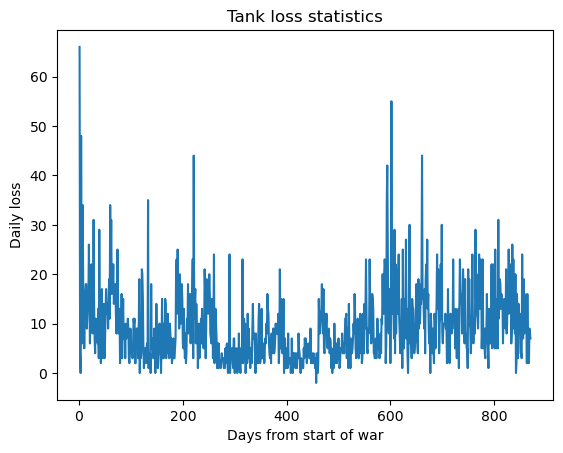

In [49]:
ru_equip_deaths_df["tank"].diff(1).plot.line(y="day")
plt.title("Tank loss statistics")
plt.xlabel("Days from start of war")
plt.ylabel("Daily loss")
# monthly_mean_tank_loss = 


Text(0, 0.5, 'Daily loss')

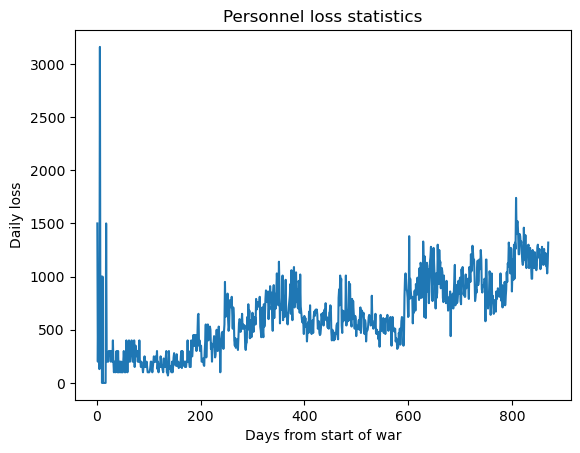

In [50]:

ru_pers_deaths_df["personnel"].diff(1).plot.line(y="day")
plt.title("Personnel loss statistics")
plt.xlabel("Days from start of war")
plt.ylabel("Daily loss")
# rework and relabel these plots

In [9]:
# stationarity check for our time series data. This will be important for our SARIMA model 

def check_stationarity(timeseries): 
    # Perform the Dickey-Fuller test 
    result = adfuller(timeseries, autolag='AIC') 
    p_value = result[1] 
    print(f'ADF Statistic: {result[0]}') 
    print(f'p-value: {p_value}') 
    print('Stationary' if p_value < 0.05 else 'Non-Stationary') 

check_stationarity(ru_pers_deaths_df["personnel"].diff(1).dropna())


ADF Statistic: -1.267107995833419
p-value: 0.6440829365591206
Non-Stationary


In [10]:
ru_pers_deaths_df["personnel"].diff(1).dropna()


1      1500.0
2       200.0
3       800.0
4       410.0
5       130.0
        ...  
866    1100.0
867    1110.0
868    1030.0
869    1120.0
870    1320.0
Name: personnel, Length: 870, dtype: float64

In [11]:
ru_equip_deaths_df["vehicles and fuel tanks"].iloc[0]

nan

In [12]:
ru_equip_deaths_df.info()
# We know only the first 64 entries have nans. merge the data from these two fields
for i in range(65):
    if pd.isna(ru_equip_deaths_df["vehicles and fuel tanks"].iloc[i]):
        ru_equip_deaths_df["vehicles and fuel tanks"].iloc[i] = ru_equip_deaths_df["fuel tank"].iloc[i] \
        + ru_equip_deaths_df["military auto"].iloc[i] 

ru_equip_deaths_df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 871 entries, 0 to 870
Data columns (total 20 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   index                      871 non-null    int64  
 1   date                       871 non-null    object 
 2   day                        871 non-null    int64  
 3   aircraft                   871 non-null    int64  
 4   helicopter                 871 non-null    int64  
 5   tank                       871 non-null    int64  
 6   APC                        871 non-null    int64  
 7   field artillery            871 non-null    int64  
 8   MRL                        871 non-null    int64  
 9   military auto              65 non-null     float64
 10  fuel tank                  65 non-null     float64
 11  drone                      871 non-null    int64  
 12  naval ship                 871 non-null    int64  
 13  anti-aircraft warfare      871 non-null    int64  

C:\Users\19132\AppData\Local\Temp\ipykernel_23672\1009285897.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ru_equip_deaths_df["vehicles and fuel tanks"].iloc[i] = ru_equip_deaths_df["fuel tank"].iloc[i] \
C:\Users\19132\AppData\Local\Temp\ipykernel_23672\1009285897.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ru_equip_deaths_df["vehicles and fuel tanks"].iloc[i] = ru_equip_deaths_df["fuel tank"].iloc[i] \
C:\Users\19132\AppData\Local\Temp\ipykernel_23672\1009285897.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https:/

## Create Diff columns

In [13]:
def create_diff_columns(df_name, column_name):
    """
    Create a new dataframe column for the daily differences in loss rates 
    args: pandas dataframe, str name for column


    """
    df_name[f"{column_name} diff"] = df_name[f"{column_name}"].diff(1)
    df_name[f"{column_name} diff"][0] = df_name[f"{column_name}"][0]

# these are the four I will focus on 
create_diff_columns(ru_equip_deaths_df, "vehicles and fuel tanks")
create_diff_columns(ru_equip_deaths_df, "tank")
create_diff_columns(ru_equip_deaths_df, "APC")
create_diff_columns(ru_equip_deaths_df, "field artillery")
create_diff_columns(ru_pers_deaths_df, "personnel")



# Create columns for a Datetime object and for the int month and int year for calculations
#these are only made once for each csv
ru_equip_deaths_df["Dt_OBJ"] = ru_equip_deaths_df['date'].apply(lambda x : datetime.strptime(x, '%Y-%m-%d'))
ru_equip_deaths_df["Int_month"] = ru_equip_deaths_df["Dt_OBJ"].dt.month
ru_equip_deaths_df["Int_year"] = ru_equip_deaths_df["Dt_OBJ"].dt.year

ru_pers_deaths_df["Dt_OBJ"] = ru_pers_deaths_df['date'].apply(lambda x : datetime.strptime(x, '%Y-%m-%d'))
ru_pers_deaths_df["Int_month"] = ru_pers_deaths_df["Dt_OBJ"].dt.month
ru_pers_deaths_df["Int_year"] = ru_pers_deaths_df["Dt_OBJ"].dt.year


# For season calculations we fake the year december is in so visualizations won't be a problem
#actual datetime value will not change or interfere with data
for i in range(len(ru_equip_deaths_df)):
        if ru_equip_deaths_df["Int_month"].iloc[i] == 12:
            ru_equip_deaths_df.iloc[i,-1] += 1 

C:\Users\19132\AppData\Local\Temp\ipykernel_23672\1173600529.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_name[f"{column_name} diff"][0] = df_name[f"{column_name}"][0]
C:\Users\19132\AppData\Local\Temp\ipykernel_23672\1173600529.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_name[f"{column_name} diff"][0] = df_name[f"{column_name}"][0]
C:\Users\19132\AppData\Local\Temp\ipykernel_23672\1173600529.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#ret

Text(0, 0.5, 'Daily loss')

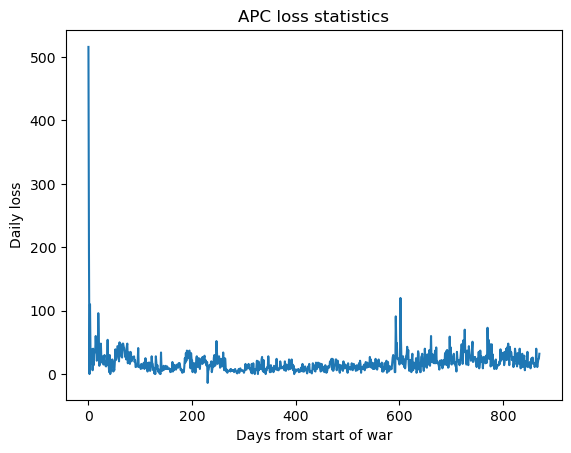

In [53]:
ru_equip_deaths_df["APC diff"].plot.line(y="day")
plt.title("APC loss statistics")
plt.xlabel("Days from start of war")
plt.ylabel("Daily loss")

Text(0, 0.5, 'Daily loss')

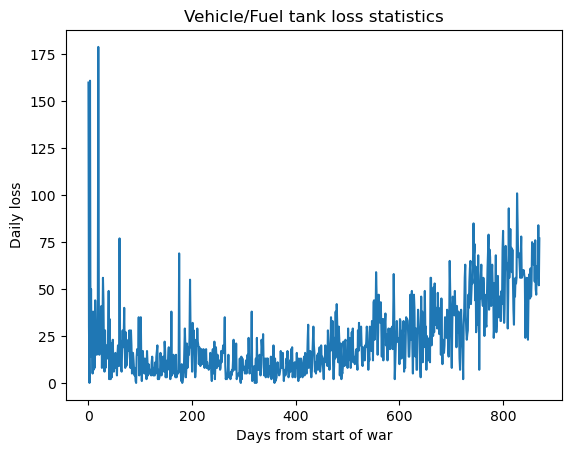

In [52]:
ru_equip_deaths_df["vehicles and fuel tanks diff"].plot.line(y="day")
plt.title("Vehicle/Fuel tank loss statistics")
plt.xlabel("Days from start of war")
plt.ylabel("Daily loss")

Text(0, 0.5, 'Daily loss')

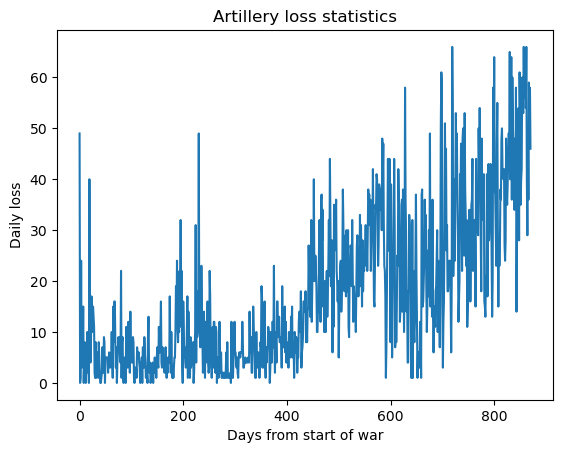

In [51]:
ru_equip_deaths_df["field artillery diff"].plot.line(y="day")
plt.title("Artillery loss statistics")
plt.xlabel("Days from start of war")
plt.ylabel("Daily loss")

## Groupby months to evaluate each monthly trend

#### We'll use this to guide our seasonality checks

In [15]:
# currently deprecated other than creating the DT objects. 

# ru_equip_deaths_df["Dt_OBJ"] = ru_equip_deaths_df['date'].apply(lambda x : datetime.strptime(x, '%Y-%m-%d'))

# # ru_equip_deaths_df.groupby(pd.Grouper(key='date', freq='M'))

# # type(ru_equip_deaths_df["Dt_OBJ"])
# # # ru_equip_deaths_df["Dt_OBJ"]
# # # ru_equip_deaths_df.head()
# # def monthly_analysis(df_obj, c_name):
# #     by_month_df = ru_equip_deaths_df.groupby(pd.Grouper(key='Dt_OBJ', freq='M'))["tank diff"]
    




# # ru_by_month_df = ru_equip_deaths_df.groupby(pd.Grouper(key='Dt_OBJ', freq='M'))
# # ru_by_month_df.sum()["tank diff"].plot.line()
# # ru_by_month_df.sum()["tank diff"]


# ru_pers_deaths_df["pers diff"] = ru_pers_deaths_df["personnel"].diff(1)
# ru_pers_deaths_df["pers diff"][0] = 2800
# # ru_pers_deaths_df["pers diff"]

# ru_pers_deaths_df["Dt_OBJ"] = ru_pers_deaths_df['date'].apply(lambda x : datetime.strptime(x, '%Y-%m-%d'))
# ru_pers_deaths_df.head()

# ru_pers_by_month_df = ru_pers_deaths_df.groupby(pd.Grouper(key='Dt_OBJ', freq='M'))
# ru_pers_by_month_df.sum()["pers diff"]
# ru_pers_deaths_df['Dt_OBJ'][1].month


# Create season dataframes

In [16]:
def return_seasonal_dataframes(df_name, column_name):
    '''Only return season dataframes
    Args: dataframe, str for column
    returns four dataframes in order spring, summer, fall, winter
    '''
    springdf = df_name[(df_name["Int_month"] == 3) | (df_name["Int_month"] == 4) |
                                                (df_name["Int_month"] == 5)]
    summerdf = df_name[(df_name["Int_month"] == 6) | (df_name["Int_month"] == 7) |
                                                (df_name["Int_month"] == 8)]
    falldf = df_name[(df_name["Int_month"] == 9) | (df_name["Int_month"] == 10) |
                                                (df_name["Int_month"] == 11)]
    winterdf = df_name[(df_name["Int_month"] == 12) | (df_name["Int_month"] == 1) |
                                                (df_name["Int_month"] == 2)]
    
    return springdf,summerdf,falldf,winterdf

def create_seasonal_comparisons(df_name, column_name):
    # split the given dataframe into seasons, plot the dataframes
    # run T-Tests against spring and print results

    
    #df_name["Int_month"] = df_name["Dt_OBJ"].dt.month

    ru_deaths_summerdf = df_name[(df_name["Int_month"] == 6) | (df_name["Int_month"] == 7) |
                                                (df_name["Int_month"] == 8)]
    ru_deaths_falldf = df_name[(df_name["Int_month"] == 9) | (df_name["Int_month"] == 10) |
                                                (df_name["Int_month"] == 11)]
    ru_deaths_winterdf = df_name[(df_name["Int_month"] == 12) | (df_name["Int_month"] == 1) |
                                                (df_name["Int_month"] == 2)]
    ru_deaths_springdf = df_name[(df_name["Int_month"] == 3) | (df_name["Int_month"] == 4) |
                                                (df_name["Int_month"] == 5)]
    
    ru_deaths_summerdf[f"{column_name}"].plot()
    ru_deaths_springdf[f"{column_name}"].plot()
    ru_deaths_falldf[f"{column_name}"].plot()
    ru_deaths_winterdf[f"{column_name}"].plot()
    print("Summer mean:", ru_deaths_summerdf[f"{column_name}"].mean())
    print("Spring mean:" ,ru_deaths_springdf[f"{column_name}"].mean())
    print("Fall mean:" ,ru_deaths_falldf[f"{column_name}"].mean())
    print("Winter mean:" ,ru_deaths_winterdf[f"{column_name}"].mean())
    
    print("Winter vs Spring:" , stats.ttest_ind(ru_deaths_winterdf[f"{column_name}"], ru_deaths_springdf[f"{column_name}"]))
    print("Summer vs Spring:" ,stats.ttest_ind(ru_deaths_summerdf[f"{column_name}"], ru_deaths_springdf[f"{column_name}"]))
    print("Fall vs Spring:" ,stats.ttest_ind(ru_deaths_falldf[f"{column_name}"], ru_deaths_springdf[f"{column_name}"]))

# Add color vairable, change seasonal plot


def trend_line_w_outliers(df_name, column_name, draw_data=False,color=("blue","yellow","green","grey"), draw_trend=True ):
    ''' slightly misleading, but calls for draw trend line do all the work
    split DF into seasons, with options to draw the data to a plot, the trend line, or both
    color expects a 4-tuple of string color names for plotting
    Args: dataframe, str, boolean, 4-len tuple, boolean
    '''
    
    ru_deaths_summerdf = df_name[(df_name["Int_month"] == 6) | (df_name["Int_month"] == 7) |
                                                (df_name["Int_month"] == 8)]
    ru_deaths_falldf = df_name[(df_name["Int_month"] == 9) | (df_name["Int_month"] == 10) |
                                                (df_name["Int_month"] == 11)]
    ru_deaths_winterdf = df_name[(df_name["Int_month"] == 12) | (df_name["Int_month"] == 1) |
                                                (df_name["Int_month"] == 2)]
    ru_deaths_springdf = df_name[(df_name["Int_month"] == 3) | (df_name["Int_month"] == 4) |
                                                (df_name["Int_month"] == 5)]
    plt.figure(figsize=(12, 6))

    summer_std = ru_deaths_summerdf[f"{column_name}"].std()
    fall_std = ru_deaths_falldf[f"{column_name}"].std()
    winter_std = ru_deaths_winterdf[f"{column_name}"].std()
    spring_std = ru_deaths_springdf[f"{column_name}"].std()
    if draw_data:
        plt.plot(df_name["Dt_OBJ"],df_name[f"{column_name}"])
    
    print("Spring:")
    draw_trend_line(ru_deaths_springdf,column_name,color[0],draw_trend)
    print("Summer:")
    draw_trend_line(ru_deaths_summerdf,column_name,color[1],draw_trend)
    print("Fall:")
    draw_trend_line(ru_deaths_falldf,column_name,color[2],draw_trend)
    print("Winter:")
    draw_trend_line(ru_deaths_winterdf,column_name,color[3],draw_trend)
   
    
    

def draw_trend_line(df_name, column_name, color_name, draw_trend=True):
    #Attach december to the next year for plotting purposes
    outlier_counter = 0


    yearly_data = df_name.groupby(df_name["Int_year"])
    df_name_mean = df_name[f"{column_name}"].median()
    
    for year, data in yearly_data:
        # print("yearly", year, data.head())
        df_name_std = data[f"{column_name}"].std()
        df_name_mean = data[f"{column_name}"].mean()
        # print(f"{year}:STD : {df_name_std}")
        # print(f"{year}:mean : {df_name_mean}")
        
        first_point = data.iloc[0]
        last_point = data.iloc[-1]
        if draw_trend:
            plt.plot([first_point["Dt_OBJ"], last_point["Dt_OBJ"]], 
                    [first_point[f'{column_name}'], last_point[f'{column_name}']], 
                    marker='o', color=color_name)
        
        for points in range(len(data)):
            
            if (data[f"{column_name}"].iloc[points] > (df_name_std * 2) + df_name_mean):
                #or (df_name[f"{column_name}"].iloc[points] < df_name_mean - df_name_std)
                # print(" Outlier at ",data["Int_month"].iloc[points],  data[f"{column_name}"].iloc[points])
                outlier_counter += 1
                plt.plot(data["Dt_OBJ"].iloc[points],data[f"{column_name}"].iloc[points], marker='x',color="black")

    
    plt.xlabel('Date')
    plt.ylabel('Value')
    plt.title('Trend Lines for Each Month')
    plt.legend()
    plt.grid(True)
    print(f"Total season outliers: {outlier_counter}")

# y = df['passengers']
# x = df['lag_1']
# model = sm.OLS(y, sm.add_constant(x))
# results = model.fit()
# b, m = results.params
# IQR, standard deviation to find outliers. plot them, take linear regression lines for each season

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Spring:
Total season outliers: 12
Summer:
Total season outliers: 12
Fall:
Total season outliers: 6
Winter:
Total season outliers: 8


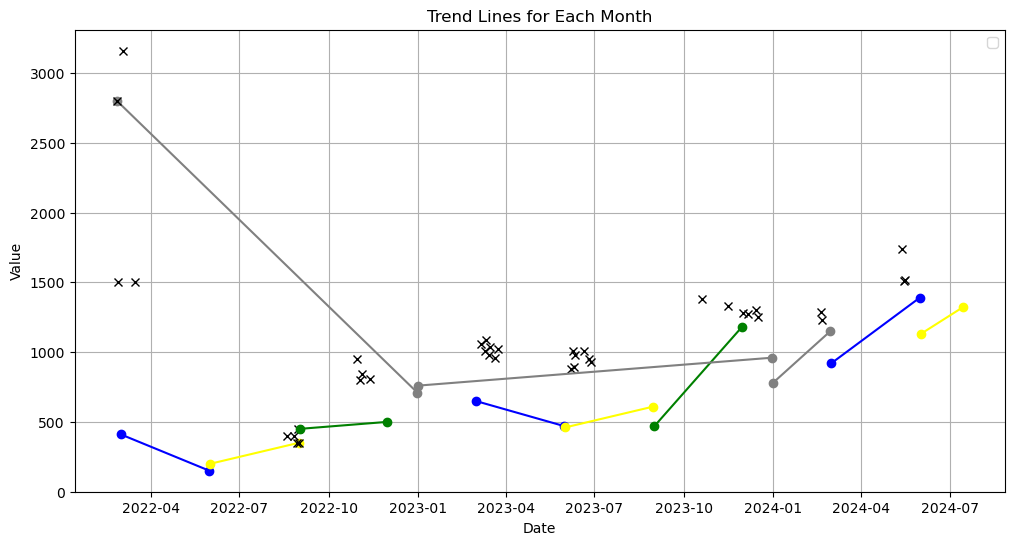

In [17]:
# for i in range(len(ru_pers_deaths_df)):
#         if ru_pers_deaths_df["Int_month"].iloc[i] == 12:
#             ru_pers_deaths_df.iloc[i, ru_pers_deaths_df.columns.get_loc('Int_year')] += 1

trend_line_w_outliers(ru_pers_deaths_df, "personnel diff",draw_data=False)


# SNS.REGPLOT

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Spring:
Total season outliers: 7
Summer:
Total season outliers: 9
Fall:
Total season outliers: 5
Winter:
Total season outliers: 8


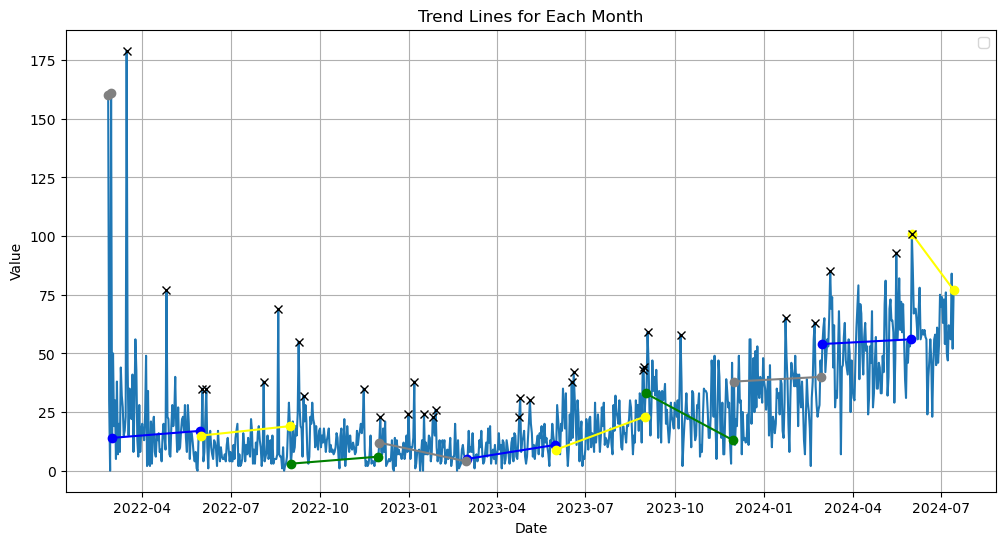

In [46]:
trend_line_w_outliers(ru_equip_deaths_df, "vehicles and fuel tanks diff",draw_data=True,draw_trend=True)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Spring:
Total season outliers: 13
Summer:
Total season outliers: 11
Fall:
Total season outliers: 5
Winter:
Total season outliers: 6


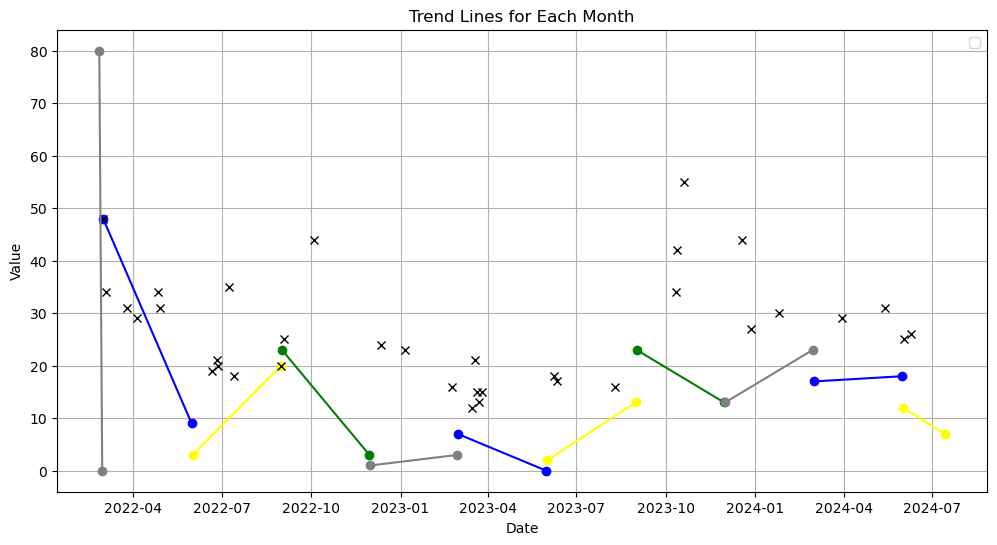

In [18]:
trend_line_w_outliers(ru_equip_deaths_df, "tank diff",draw_data=False,draw_trend=True)


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Spring:
Total season outliers: 10
Summer:
Total season outliers: 12
Fall:
Total season outliers: 4
Winter:
Total season outliers: 10


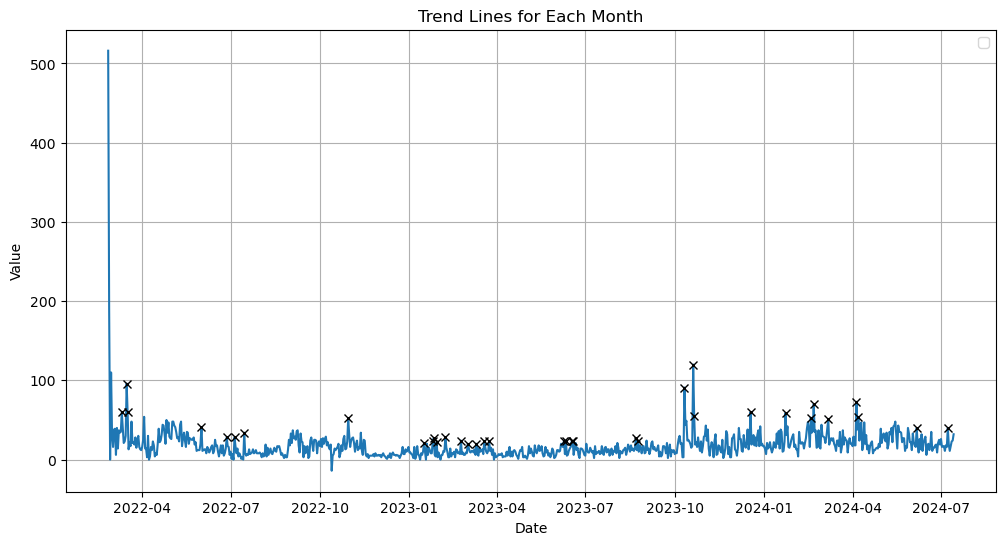

In [19]:
trend_line_w_outliers(ru_equip_deaths_df, "APC diff",draw_data=True,draw_trend=False)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Spring:
Total season outliers: 8
Summer:
Total season outliers: 7
Fall:
Total season outliers: 4
Winter:
Total season outliers: 10


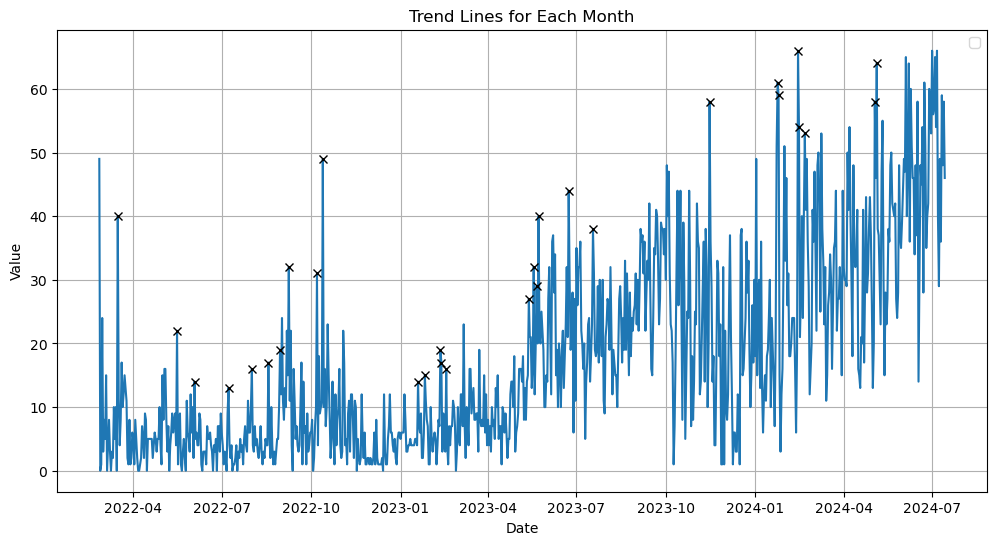

In [20]:
trend_line_w_outliers(ru_equip_deaths_df, "field artillery diff",draw_data=True,draw_trend=False)

<Axes: xlabel='Dt_OBJ'>

<Figure size 1200x600 with 0 Axes>

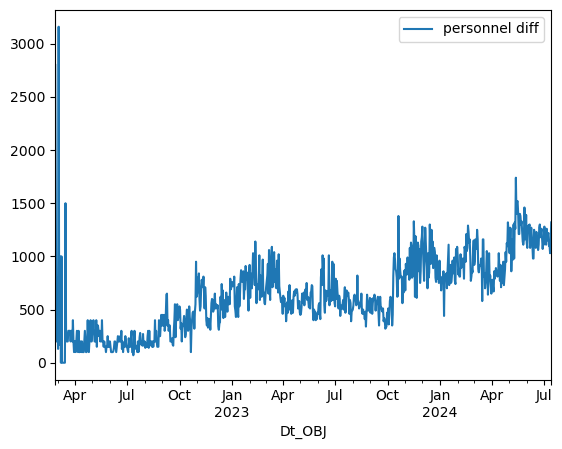

In [21]:
plt.figure(figsize=(12, 6))
ru_pers_deaths_df.plot.line(x="Dt_OBJ", y="personnel diff")

Summer mean: 543.640350877193
Spring mean: 644.0579710144928
Fall mean: 586.3736263736264
Winter mean: 814.3783783783783
Winter vs Spring: TtestResult(statistic=5.017674835775379, pvalue=7.492003112182176e-07, df=459.0)
Summer vs Spring: TtestResult(statistic=-2.857656987339838, pvalue=0.004445026486195426, df=502.0)
Fall vs Spring: TtestResult(statistic=-1.7041908772484564, pvalue=0.08902665247042875, df=456.0)


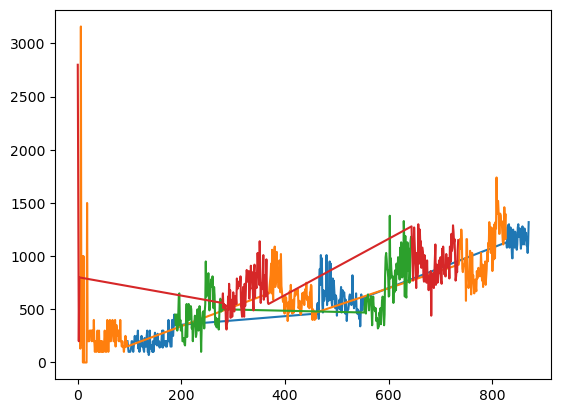

In [22]:

create_seasonal_comparisons(ru_pers_deaths_df, "personnel diff")

#winter most dangerous month for personnel


Summer mean: 13.236842105263158
Spring mean: 20.692028985507246
Fall mean: 18.10989010989011
Winter mean: 20.464864864864865
Winter vs Spring: TtestResult(statistic=-0.08436825558573077, pvalue=0.932800429904612, df=459.0)
Summer vs Spring: TtestResult(statistic=-7.250670292659196, pvalue=1.5785123956627424e-12, df=502.0)
Fall vs Spring: TtestResult(statistic=-1.9254270920005088, pvalue=0.05479750622145571, df=456.0)


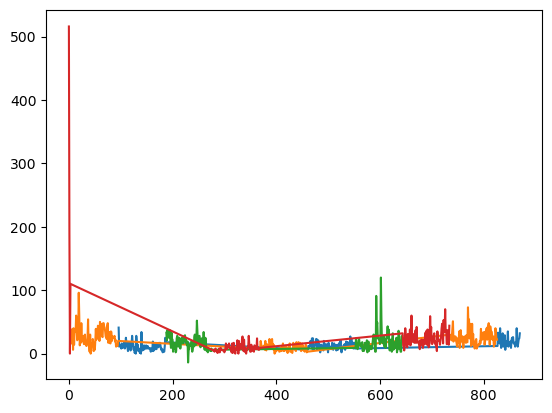

In [23]:
create_seasonal_comparisons(ru_equip_deaths_df, "APC diff")
#highest losses appear to be in the spring but not by much

Summer mean: 20.223684210526315
Spring mean: 17.108695652173914
Fall mean: 17.653846153846153
Winter mean: 14.68108108108108
Winter vs Spring: TtestResult(statistic=-1.7781400464639585, pvalue=0.07604276226537789, df=459.0)
Summer vs Spring: TtestResult(statistic=2.1918697477703715, pvalue=0.028847466821750465, df=502.0)
Fall vs Spring: TtestResult(statistic=0.4050080352472471, pvalue=0.6856615321802995, df=456.0)


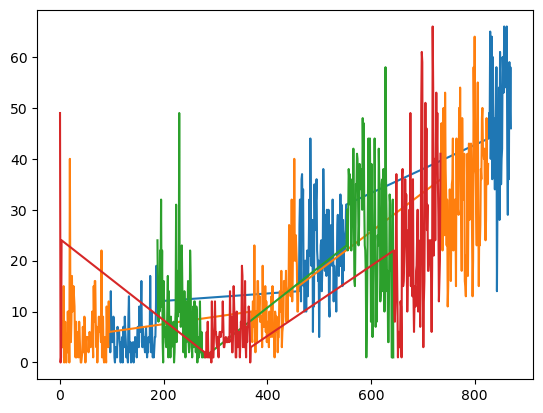

In [24]:
create_seasonal_comparisons(ru_equip_deaths_df, "field artillery diff")
# summer most dangerous month

Summer mean: 7.578947368421052
Spring mean: 9.98913043478261
Fall mean: 11.291208791208792
Winter mean: 9.005405405405405
Winter vs Spring: TtestResult(statistic=-1.254033481936413, pvalue=0.21046811397475912, df=459.0)
Summer vs Spring: TtestResult(statistic=-4.092543799396213, pvalue=4.9708032412739606e-05, df=502.0)
Fall vs Spring: TtestResult(statistic=1.7642222374380507, pvalue=0.07836405967214724, df=456.0)


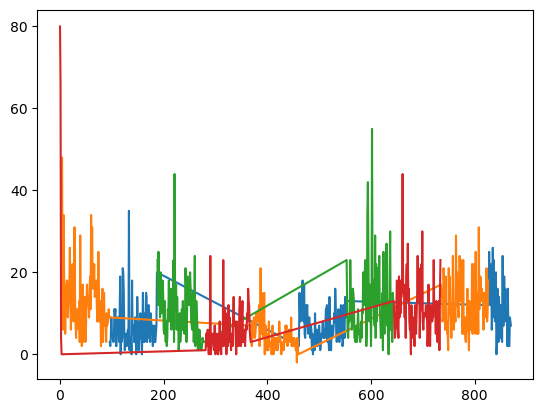

In [25]:
create_seasonal_comparisons(ru_equip_deaths_df, "tank diff")
# no statistical significance between winter and fall, but summer is significantly less

#negative statistic means 1 is smaller, positive means larger

Summer mean: 23.42105263157895
Spring mean: 27.735507246376812
Fall mean: 19.65934065934066
Winter mean: 21.43243243243243
Winter vs Spring: TtestResult(statistic=-2.9461771939570958, pvalue=0.0033809542156485973, df=459.0)
Summer vs Spring: TtestResult(statistic=-2.146652816548352, pvalue=0.032299423047936045, df=502.0)
Fall vs Spring: TtestResult(statistic=-4.263682573292443, pvalue=2.4454569264915822e-05, df=456.0)


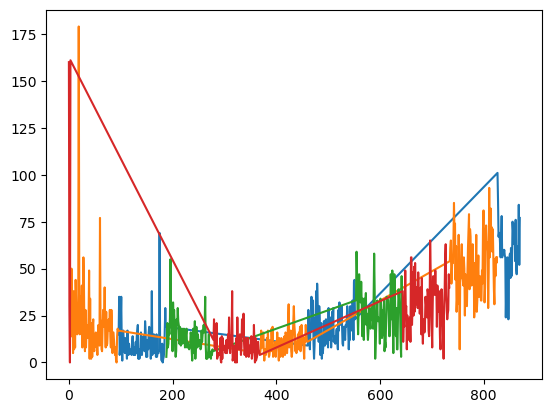

In [26]:

create_seasonal_comparisons(ru_equip_deaths_df, "vehicles and fuel tanks diff")
# spring by a pretty good margin, statistically significant 

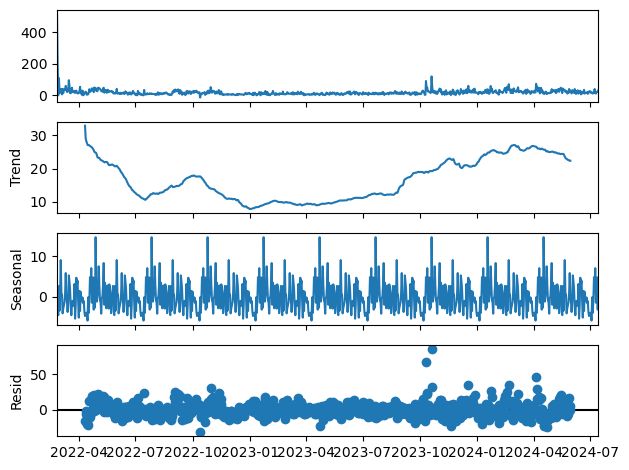

In [56]:
def seasonal_decomposition(df_name, column_name):

    equip_analysis = df_name.loc[0::,["Dt_OBJ", f"{column_name} diff"]]
    equip_analysis.set_index("Dt_OBJ", inplace=True)
    decompose_result = seasonal_decompose(equip_analysis,period=90)
    trend = decompose_result.trend
    seasonal = decompose_result.seasonal
    resid_season = decompose_result.resid
    decompose_result.plot()
    return trend, seasonal, resid_season, decompose_result

apc_trend, apc_seasonal, apc_resid, APC_decomp = seasonal_decomposition(ru_equip_deaths_df,"APC")

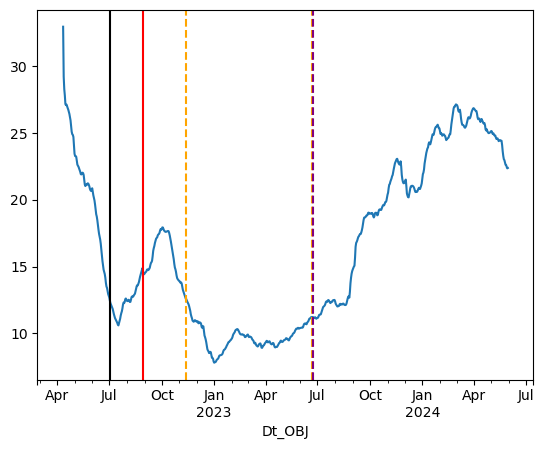

In [61]:
apc_trend.plot()
plt.axvline(x=datetime(2022,8,29),color="red")
plt.axvline(x=datetime(2022,11,12),color="orange",linestyle="--")
plt.axvline(x=datetime(2023,6,22),color="orange",linestyle="--")
plt.axvline(x=datetime(2023,6,23),color="purple",linestyle="--")
plt.axvline(x=datetime(2022,7,3),color="black")

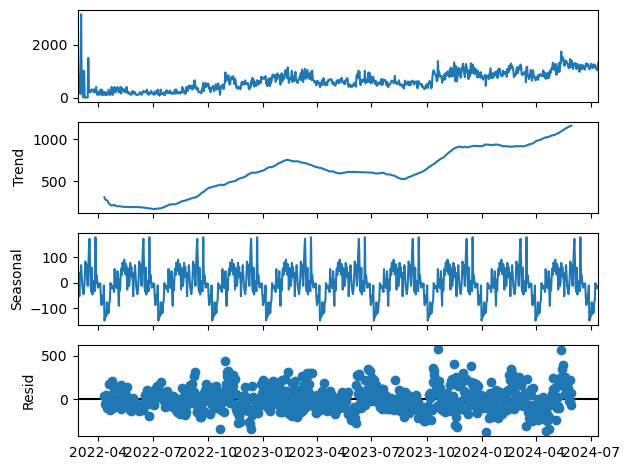

In [29]:
pers_trend, pers_seasonal, pers_resid, pers_decomp = seasonal_decomposition(ru_pers_deaths_df,"personnel")

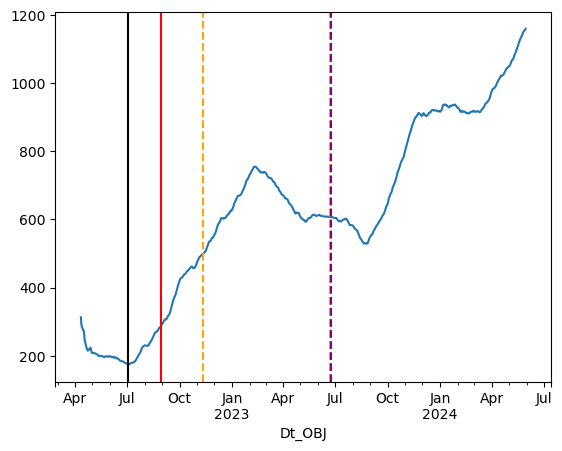

In [64]:
pers_trend.plot()
plt.axvline(x=datetime(2022,8,29),color="red")
plt.axvline(x=datetime(2022,11,12),color="orange",linestyle="--")
plt.axvline(x=datetime(2023,6,22),color="orange",linestyle="--")
plt.axvline(x=datetime(2023,6,22),color="orange",linestyle="--")
plt.axvline(x=datetime(2023,6,23),color="purple",linestyle="--")
plt.axvline(x=datetime(2022,7,3),color="black")

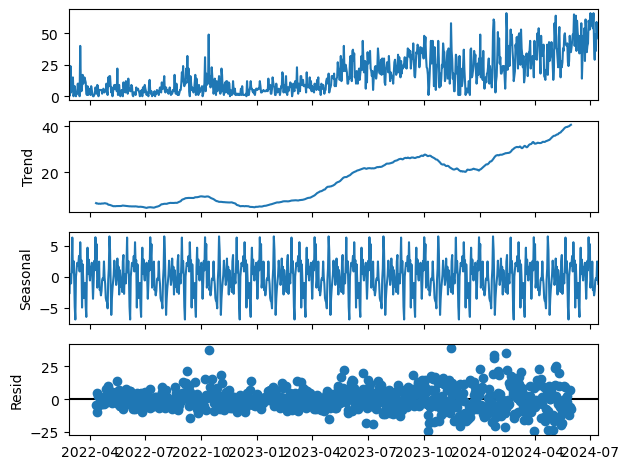

In [62]:
arty_trend, arty_seasonal, arty_resid, arty_decomp = seasonal_decomposition(ru_equip_deaths_df,"field artillery")

Text(0.5, 0, '')

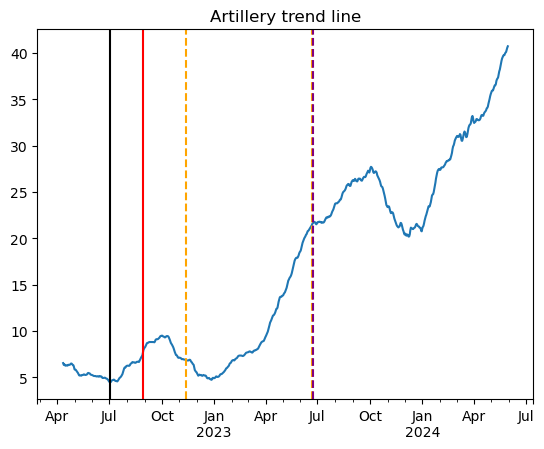

In [65]:

arty_trend.plot()
plt.title("Artillery trend line")
plt.axvline(x=datetime(2022,8,29),color="red") # beginning of ukr counteroffensives
plt.axvline(x=datetime(2022,11,12),color="orange",linestyle="--") #start of stalemate period
plt.axvline(x=datetime(2023,6,22),color="orange",linestyle="--") #end of second stalemate
plt.axvline(x=datetime(2023,6,23),color="purple",linestyle="--") #2nd ukr counteroffensive
plt.axvline(x=datetime(2022,7,3),color="black") #Bakhmut
plt.xlabel("")

In [31]:
#testing lags at different areas

# group into seasons, compare means of seasons, drop back into days, t-test
# seasonal decomposition sarima

# outlier analysis

### Checks for stationarity

In [32]:
check_stationarity(ru_equip_deaths_df["vehicles and fuel tanks diff"])

ADF Statistic: -2.042521464734165
p-value: 0.2682455735285929
Non-Stationary


<Axes: >

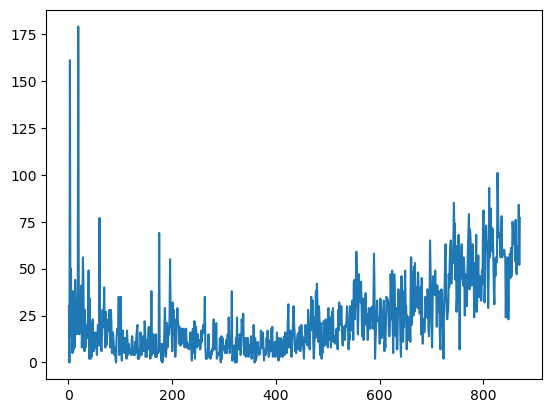

In [33]:
ru_equip_deaths_df["vehicles and fuel tanks"].diff(1).dropna().plot.line(y="day")

In [34]:
check_stationarity(ru_equip_deaths_df["tank"].diff(1).dropna())



ADF Statistic: -5.624366205678061
p-value: 1.12617486735012e-06
Stationary


<Axes: xlabel='Lag', ylabel='Autocorrelation'>

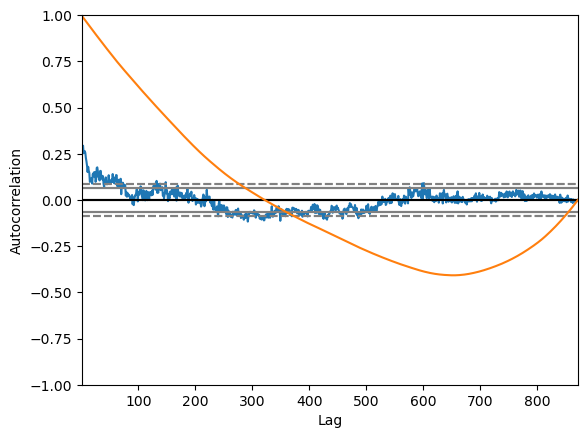

In [35]:
from pandas.plotting import autocorrelation_plot
autocorrelation_plot(ru_equip_deaths_df["tank"].diff(1).dropna())
autocorrelation_plot(ru_equip_deaths_df["tank"].dropna())


<Axes: xlabel='Lag', ylabel='Autocorrelation'>

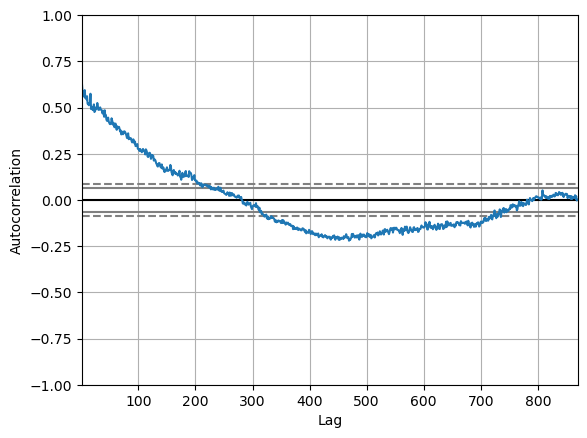

In [36]:
autocorrelation_plot(ru_equip_deaths_df["vehicles and fuel tanks"].diff(1).dropna())

In [37]:
ru_equip_deaths_df["tank"].diff(1).dropna().hist()
plt.close()

In [38]:
ru_pers_deaths_df["personnel"].diff(-1).dropna().hist()
plt.close()

In [39]:
autocorrelation_plot(ru_pers_deaths_df["personnel"].diff(-1).dropna())
plt.close()

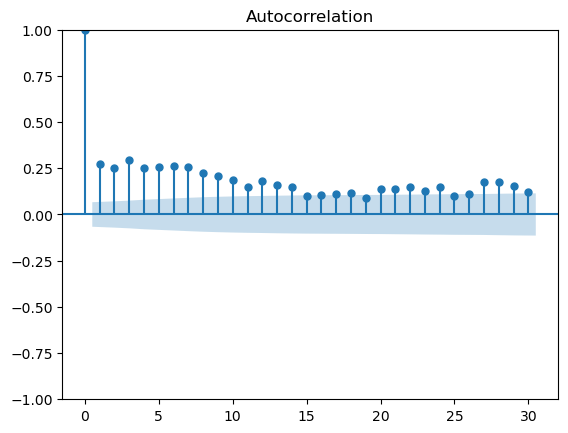

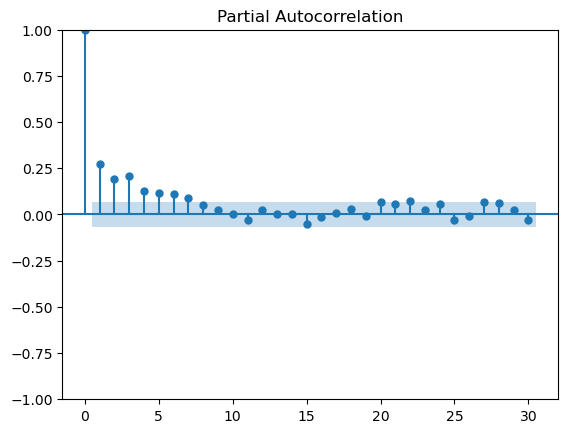

In [40]:
plot_acf(ru_equip_deaths_df["tank"].diff(1).dropna()) 
plot_pacf(ru_equip_deaths_df["tank"].diff(1).dropna()) 
plt.show()
plt.close()

In [41]:
autocorrelation_plot(ru_equip_deaths_df["tank"].diff(1).dropna())
plt.close()

In [42]:
# use pd.cut to bin by seasons (i.e. spring, summer, fall, winter), according to the ukrainian climate.
# hypothesis, there will be a statistically significant change in casualty rates 
# across vehicle and personnel in spring
# Furthermore that change will be lower than summer and fall casualty rates

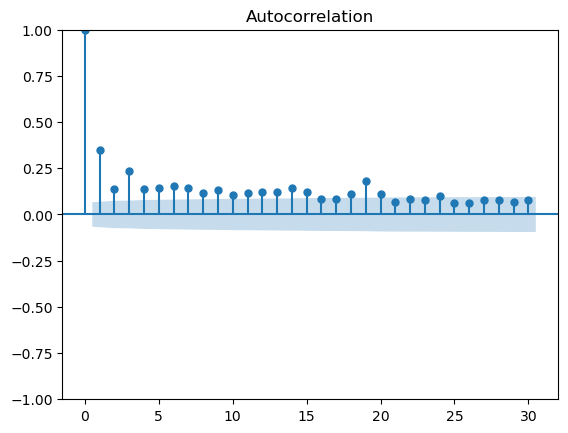

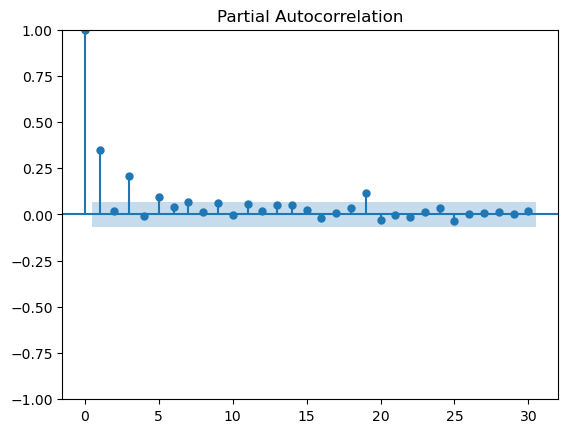

In [43]:
apc_spring_df, apc_summer_df, apc_fall_df, apc_winter_df = return_seasonal_dataframes(ru_equip_deaths_df,'APC diff')
plot_acf(ru_equip_deaths_df["APC diff"]) 
plot_pacf(ru_equip_deaths_df["APC diff"]) 
plt.show()
plt.close()

In [44]:
plt.close()

# The SARIMA MODELS

## Code below here is Fitting and reviewing models.
##### These may be computationally expensive!

In [ ]:
# wrap in

from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error

#Split the train and test
X = ru_equip_deaths_df["APC diff"]
tscsv = TimeSeriesSplit()
for i, (train_index, test_index) in enumerate(tscsv.split(X)):
    X_train = ru_equip_deaths_df.iloc[train_index]
    y_train = ru_equip_deaths_df.iloc[train_index]["APC diff"]
    X_test = ru_equip_deaths_df.iloc[test_index]
    y_test = ru_equip_deaths_df.iloc[test_index]["APC diff"]

    # forecast

In [ ]:
# GRID SEARCH
# this would take a long time to implement, will run auto arima for a ballpark and try to manually find best fit
# make sure you have a large chunk of memory. searching for this m value is very expensive

Arima_model= auto_arima(y_train, start_p=1, 
                        start_q=1, 
                        max_p=8, 
                        max_q=8, 
                        start_P=0, 
                        start_Q=0, 
                        max_P=8, 
                        max_Q=8,
                        m=30, 
                        seasonal=True, 
                        trace=True, 
                        d=1, D=1, 
                        error_action='warn', 
                        suppress_warnings=True, 
                        random_state = 20, 
                        n_fits=30)


# def parameter_grid_search()

# def sarima_forecast(history, config):
#  order, sorder, trend = config
#  model = SARIMAX(history, order=order, seasonal_order=sorder, trend=trend, enforce_stationarity=False, enforce_invertibility=False)
 
#  model_fit = model.fit(disp=False)
#  # make one step forecast
#  yhat = model_fit.predict(len(history), len(history))
#  return yhat[0]

# def model_validation_stepper(df_name, n_test, cfg):
#     predictions = list()
#ARIMA(2,1,0)(7,1,0)[12] 


In [ ]:
Arima_model.fit(y_train)

forecaster = Arima_model.predict(len(y_test)-1)


In [ ]:
type(forecaster)

In [ ]:
forecaster.plot.line()

In [ ]:
#  ARIMA(2,1,0)(7,1,0)[12] 


# Define SARIMA parameters by results of autoarima.  worst case try these
p, d, q = 2, 1, 0 
P, D, Q, s = 7, 1, 0, 30   
  
# Fit the SARIMA model 
# ar_model = ARIMA(ru_equip_deaths_df["tank"].diff(1).dropna(), order=(p,d,q))
model = SARIMAX(y_train, order=(p, d, q), seasonal_order=(P, D, Q, s)) 
results = model.fit() 


In [ ]:
predictions = results.predict(start=0, end=len(y_train)-1)



In [ ]:
forecast = results.get_forecast(steps=90)

forecast_df = pd.DataFrame(forecast.predicted_mean)
forecast_df

In [ ]:
results.summary()

In [ ]:
# fig, ax = plt.subplots()
forecast= results.get_forecast(steps=len(y_test)-1)
forecast_df = pd.DataFrame(forecast.predicted_mean)
forecast_df

In [ ]:
inp = input()
if inp in ru_equip_deaths_df.columns:
    print("it work")

In [ ]:


# plt.plot(y_train.index,y_test[1])
plt.plot()
y_train.plot.line()
plt.plot(forecaster.index,forecaster.values)
y_test.plot.line()



#### losses per day cannot be negative
##### Roll through predictions and set negative predicts to zero

In [ ]:
predictions[predictions < 0] = 0


In [ ]:
ru_equip_deaths_df["APC diff"].plot.line()
predictions.plot.line()


In [ ]:
residuals = ru_equip_deaths_df["APC diff"] - predictions
residuals.dropna(inplace=True)

residuals = pd.DataFrame(residuals)
residuals.reset_index()
residuals.columns = ['diff']


fig, ax = plt.subplots(figsize=(14, 4))
# ax.scatter(range(len(predictions)), predictions, color="red", label="y true values")
ax.scatter(range(len(residuals)), residuals, color="k", label='y_hat')
# for i in range(1, len(predictions)):
#     plt.vlines(i,residuals['diff'][i],predictions[i],color="k", linestyle="--")

    # 0,y_hat[0],y[0],color="k", linestyle="--"
ax.legend()
plt.title("AVG EXP")
plt.show()


# AIC, BIC

In [ ]:
cas_residuals = results.resid
cas_residuals


In [ ]:

predictions[predictions < 0] = 0
plt.scatter(predictions[1::], cas_residuals[1::])
plt.axhline(y=0,color="orange",linestyle="--")
plt.show()


In [ ]:
autocorrelation_plot(cas_residuals)

In [ ]:
ru_equip_deaths_df["tank"].diff(1).plot.line(y="day")

In [ ]:
ru_equip_deaths_df["tank"].plot.line(y="day")
ru_equip_deaths_df["tank"]
plt.close()